<a href="https://colab.research.google.com/github/justkittenaround/Working-Parts/blob/master/Copy_of_MPCR_Reservoir_Lorenz_CS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
from numpy import *

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# os.listdir('/content/drive/My Drive/Data1')

###Lorenz Dataset

In [ ]:
text_file = open("/content/drive/My Drive/Data1/LORENZ.DAT", "r")
lines = text_file.readlines()
lines = [line.strip("\n") for line in lines]
data = np.asarray(lines).astype(np.float64)

In [ ]:
data.shape

(16384,)

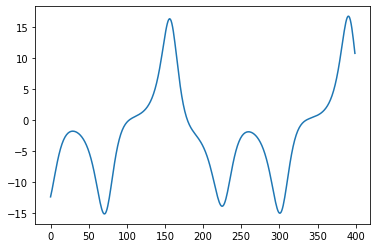

In [ ]:
plt.plot(data[200:600])

In [ ]:
m_train = 3000
m_transient = 100
m_testing = 100

n_in = 1
n_res = 500
n_out = 1

a = 0.3
r = 1e-8*np.eye(1+n_in+n_res)

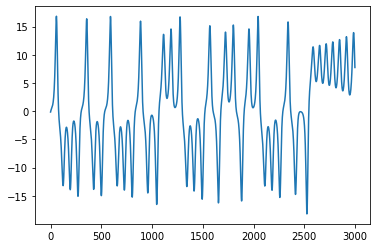

In [ ]:
plt.plot(data[0:m_train])

In [ ]:
# data += 0.1*np.random.normal(0,1,data.shape)

In [ ]:
x = np.zeros((n_res,))


X = np.zeros((1+n_in+n_res, m_train-m_transient))

Y = np.zeros((n_out,m_testing))

In [ ]:
Wi = (np.random.rand(n_res,1+n_in)-0.5); #input weights

Wr = 0.1*(np.random.randn(n_res,n_res)-0.5); #internal weights

In [ ]:
Yt = data[m_transient+1:m_train+1].T #ground truth
Yt.shape

(2900,)

###Biases

**No bias**

In [ ]:
Wr.shape

(500, 500)

In [ ]:
x.shape

(500,)

In [ ]:
for t in range(m_train):

    u = data[t]

    x = (1-a)*x + a*np.fmax(0,(Wi@r_[1,u] + Wr@x)) #r_ is concat, @ matmul, fmax is relu, a mommentum, 

    if t > m_transient: #after transient, store the stuff
        X[:,t-m_transient] = r_[1,u,x]

In [ ]:
Wo = Yt@np.linalg.pinv(X) #linalg.pinv is pseudo inverse, gt output weights

**Ridge Regression bias** -- bias #1
<br />
$ Wout=(R+A^2I)^{-1} P $
<br />
<br />
where $ R = \frac{1}{n_{max}}X'X $ , $ P = \frac{1}{n_{max}}X'Y_t $, and $ A^2 $ is some small nonnegative number and $I$ is the idendity matrix


In [ ]:
for t in range(m_train):

    u = data[t]

    x = (1-a)*x + a*np.fmax(0,(Wi@r_[1,u] + Wr@x)) #r_ is concat, @ matmul, fmax is relu, a mommentum, 

    if t > m_transient: #after transient, store the stuff
        X[:,t-m_transient] = r_[1,u,x]

In [ ]:
A = .7
R = (1/X.shape[0]) * (X@X.T)
P = (1/X.shape[0]) * (X@Yt)

Wo = np.linalg.inv((R + (np.square(A) * np.eye(X.shape[0])))) @ P

print(Wo)
print(Wo.shape)

**State noise** -- bias #2
<br />
state update with added noise vetor $v$


In [ ]:
v = 0.001

for t in range(m_train):

    u = data[t]

    x = (1-a)*x + a*np.fmax(0,(Wi@r_[1,u] + Wr@x)) + v #r_ is concat, @ matmul, fmax is relu, a mommentum, 

    if t > m_transient: #after transient, store the stuff
        X[:,t-m_transient] = r_[1,u,x]

In [ ]:
Wo = Yt@np.linalg.pinv(X)

**Changing reservoir size, N** -- bias #3

In [ ]:
n_res = 10000
x = np.zeros((n_res,))
X = np.zeros((1+n_in+n_res, m_train-m_transient))
Y = np.zeros((n_out,m_testing))
Wi = (np.random.rand(n_res,1+n_in)-0.5); #input weights
Wr = 0.1*(np.random.randn(n_res,n_res)-0.5); #internal weights

In [ ]:
for t in range(m_train):

    u = data[t]

    x = (1-a)*x + a*np.fmax(0,(Wi@r_[1,u] + Wr@x)) #r_ is concat, @ matmul, fmax is relu, a mommentum, 

    if t > m_transient: #after transient, store the stuff
        X[:,t-m_transient] = r_[1,u,x]

In [ ]:
Wo = Yt@np.linalg.pinv(X)

###**Testing**

In [ ]:
u = data[m_train]

for t in range(m_testing):

    x = (1-a)*x + a*np.fmax(0,(np.matmul(Wi, r_[1,u]) + np.matmul(Wr, x)))

    u = np.matmul(Wo, r_[1,u,x])

    Y[:,t] = u 


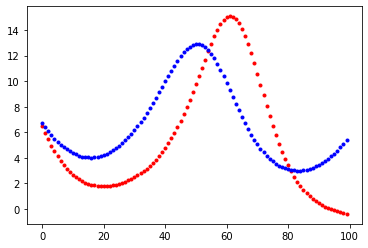

In [ ]:
plt.plot(data[m_train+1:m_train+m_testing+1],'r.')
plt.plot(Y[0,:],'b.') #prediction

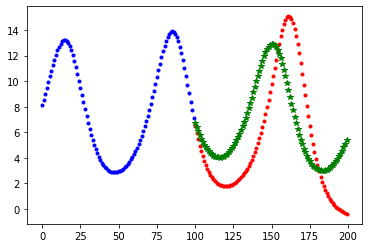

In [ ]:
plt.plot(np.arange(m_testing),data[m_train-m_testing+1:m_train+1],'b.')
plt.plot(np.arange(m_testing,2*m_testing),data[m_train+1:m_train+m_testing+1],'r.')
plt.plot(np.arange(m_testing,2*m_testing),Y[0,:],'g*')

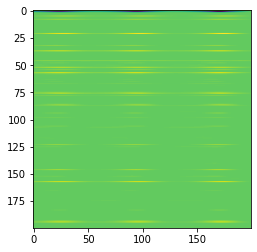

In [ ]:
plt.imshow(X[0:200,0:200])

###**Compressed Sensing** --new bias

In [ ]:
for t in range(m_train):

    u = data[t]

    x = (1-a)*x + a*np.fmax(0,(np.matmul(Wi, r_[1,u]) + np.matmul(Wr, x))) #r_ is concat, @ matmul

    if t > m_transient:
        X[:,t-m_transient] = r_[1,u,x]

In [ ]:
Wc = np.random.randn(100,X.shape[0]) #Compressed Sensing Matrix

In [ ]:
Xc = np.matmul(Wc,X)

In [ ]:
Xc.shape

(100, 2900)

In [ ]:
Wo = Yt@np.linalg.pinv(Xc) #linalg.pinv is pseudo inverse, gt output weights

In [ ]:
#testing
u = data[m_train]

for t in range(m_testing):

    x = (1-a)*x + a*np.fmax(0,(np.matmul(Wi, r_[1,u]) + np.matmul(Wr, x)))

    u = np.matmul(Wo, np.matmul(Wc,r_[1,u,x]))

    Y[:,t] = u 


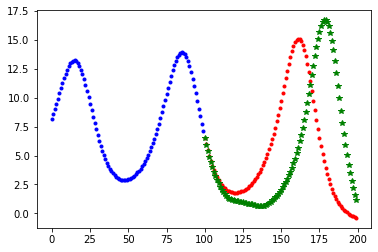

In [ ]:
plt.plot(np.arange(m_testing),data[m_train-m_testing+1:m_train+1],'b.')
plt.plot(np.arange(m_testing,2*m_testing),data[m_train+1:m_train+m_testing+1],'r.')
plt.plot(np.arange(m_testing,2*m_testing),Y[0,:],'g*')

###Flowers Dataset

In [ ]:
!pip install tflearn #for dataset

     |████████████████████████████████| 112kB 7.0MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp36-none-any.whl size=127301 sha256=d5639689adcca31418035a96397585f3872d7166c22bb170de30f452514f4655
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [ ]:
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(resize_pics=(227, 227), one_hot=True)

Instructions for updating:
non-resource variables are not supported in the long term


100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


In [ ]:
X.shape, Y.shape

((1360, 227, 227, 3), (1360, 17))

In [ ]:
#shuffle the data
r = np.random.permutation(1000)
dX = X[r,:,:,:]
dY = Y[r,:]

In [ ]:
X_train = X[0:int(0.8*dX.shape[0])]
X_val = X[int(0.8*dX.shape[0]):dX.shape[0]] 

In [ ]:
Y_train = Y[0:int(0.8*dY.shape[0])]
Y_val = Y[int(0.8*dY.shape[0]):dY.shape[0]] 

In [ ]:
X1 = X[0:256]

In [ ]:
X.shape, Y.shape

((1360, 227, 227, 3), (1360, 17))

In [ ]:
m_train = 3000
m_transient = 100
m_testing = 100

n_in = 1
n_res = 1000
n_out = 17

a = 0.3
r = 1e-8*np.eye(1+n_in+n_res)

In [ ]:
x = np.zeros((n_res,))


X = np.zeros((1+n_in+n_res, m_train-m_transient))

Y = np.zeros((n_out,m_testing))

In [ ]:
Wi = (np.random.rand(n_res,1+n_in)-0.5); #input weights

Wr = 0.1*(np.random.randn(n_res,n_res)-0.5); #internal weights

In [ ]:
Yt = dX[m_transient+1:m_train+1].T #ground truth

In [ ]:
for t in range(m_train):

    # u = data[t]
    u = X_train

    x = (1-a)*x + a*np.fmax(0,(Wi@r_[1,u] + Wr@x)) #r_ is concat, @ matmul, fmax is relu, a mommentum, 

    if t > m_transient: #after transient, store the stuff
        X[:,t-m_transient] = r_[1,u,x]

ValueError: ignored

In [ ]:
Wo = Yt@np.linalg.pinv(X) #linalg.pinv is pseudo inverse, gt output weights

In [ ]:
#testing
u = data[m_train]

for t in range(m_testing):

    x = (1-a)*x + a*np.fmax(0,(np.matmul(Wi, r_[1,u]) + np.matmul(Wr, x)))

    u = Wo@r_[1,u,x]

    Y[:,t] = u 


In [ ]:
plt.plot(data[m_train+1:m_train+m_testing+1],'r.')
plt.plot(Y[0,:],'b.') #prediction

In [ ]:
plt.plot(np.arange(m_testing),data[m_train-m_testing+1:m_train+1],'b.')
plt.plot(np.arange(m_testing,2*m_testing),data[m_train+1:m_train+m_testing+1],'r.')
plt.plot(np.arange(m_testing,2*m_testing),Y[0,:],'g*')

In [ ]:
plt.imshow(X[0:200,0:200])

In [ ]:
plt.imshow(Xc[0:200,0:200])

In [ ]:
plt.plot(X[2:,-1],'.')

In [ ]:
plt.plot(Xc[2:,-1],'.')

###Compressed Sensing Version

In [ ]:
for t in range(m_train):

    u = data[t]

    x = (1-a)*x + a*np.fmax(0,(np.matmul(Wi, r_[1,u]) + np.matmul(Wr, x))) #r_ is concat, @ matmul

    if t > m_transient:
        X[:,t-m_transient] = r_[1,u,x]

In [ ]:
Wc = np.random.randn(100,X.shape[0]) #Compressed Sensing Matrix

In [ ]:
Xc = np.matmul(Wc,X)

In [ ]:
Wo = Yt@np.linalg.pinv(Xc) #linalg.pinv is pseudo inverse, gt output weights

In [ ]:
#testing
u = data[m_train]

for t in range(m_testing):

    x = (1-a)*x + a*np.fmax(0,(np.matmul(Wi, r_[1,u]) + np.matmul(Wr, x)))

    u = np.matmul(Wo, np.matmul(Wc,r_[1,u,x]))

    Y[:,t] = u 


In [ ]:
plt.plot(np.arange(m_testing),data[m_train-m_testing+1:m_train+1],'b.')
plt.plot(np.arange(m_testing,2*m_testing),data[m_train+1:m_train+m_testing+1],'r.')
plt.plot(np.arange(m_testing,2*m_testing),Y[0,:],'g*')